To create your own corpora, train a word2vec model using the gensim library and then import it using the KeyedVectors.load_word2vec_format

In [1]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import matplotlib.pylab as plot

import numpy as np

import os

from scipy.stats import spearmanr 
from scipy.spatial.distance import cosine
from scipy.linalg import orthogonal_procrustes

from sklearn.manifold import TSNE

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Load embeddings and a testset

First we load embeddings trained on the __[English Semeval dataset](https://www.ims.uni-stuttgart.de/en/research/resources/corpora/sem-eval-ulscd-eng/)__, i.e. on two subsets of the Corpus of Historical American English (COHA)

`coha1` - embeddings trained on subset from 1810 to 1860

`coha2` - embeddings trained on subset from 1960 to 2010

In [2]:
coha1 =  KeyedVectors.load_word2vec_format(datapath(os.getcwd() + '/embeddings/coha1_win10-k5-dim100-ep30-iter1.sgns.gz'),
                                           binary=False) 
coha2 =  KeyedVectors.load_word2vec_format(datapath(os.getcwd() + '/embeddings/coha2_win10-k5-dim100-ep30-iter1.sgns.gz'),
                                           binary=False) 

In [26]:
coha1

The difference between corpora is reflected in difference between embeddings. Lets see, for example, how nearest neibours for word `pilot` changed over time. We can see that in the earlier corpus the word is associated with sea navigation, while in the later corpus the meaning shifted towards aircraft navigator.

In [3]:
coha1.similar_by_word("pilot")

[('boat', 0.6582388281822205),
 ('ship', 0.6355108618736267),
 ('sloop', 0.5993596911430359),
 ('schooner', 0.5912287831306458),
 ('frigate', 0.5773791074752808),
 ('paddle', 0.5766931772232056),
 ('shallop', 0.575290322303772),
 ('windward', 0.5710005164146423),
 ('becalmed', 0.5668559670448303),
 ('canoe', 0.5641116499900818)]

In [4]:
coha2.similar_by_word("pilot")

[('plane_nn', 0.7463921904563904),
 ('crew', 0.6648629903793335),
 ('flight', 0.6633000373840332),
 ('aircraft', 0.6505595445632935),
 ('uss', 0.649913489818573),
 ('fighter', 0.6363934278488159),
 ('helicopter', 0.6343678832054138),
 ('co-pilot', 0.6171591281890869),
 ('valujet', 0.6163130402565002),
 ('single-engine', 0.6103010773658752)]

**Your turn:** think about other English words that radically changed their meaning between the first half of 19th century and the second half of 20th century. Insert them into cells above to test your hypothesis.

In [5]:
print(coha1.similar_by_word("gay"))
print(coha2.similar_by_word("gay"))

[('lothario', 0.7040339112281799), ('joyous', 0.6585600972175598), ('blithely', 0.6554749608039856), ('graceful', 0.646531343460083), ('fantastically', 0.6295477151870728), ('garlanded', 0.62470942735672), ('waltze', 0.6234743595123291), ('lightsome', 0.6219693422317505), ('dance', 0.6200207471847534), ('parterre', 0.6117178797721863)]
[('lesbian', 0.6585097312927246), ('activist', 0.6079414486885071), ('woman', 0.5512454509735107), ('bisexual', 0.5429787039756775), ('abortion', 0.5241272449493408), ('feminist', 0.5222228169441223), ('minority', 0.5057562589645386), ('homosexual', 0.4921431839466095), ('cowardice', 0.4860481321811676), ('southerner', 0.4788546562194824)]


You probably noted that word `plane` is presented in the embedding dictionary together with a part of speech tag `plane_nn`. This is because this word belongs to a SemEval testset. The corpus was preprocessed to use only required word forms.

Lets now load the whole testset, together with manually annotated change scores.

In [6]:
graded = pd.read_csv(os.getcwd() + '/targets/english/graded.txt', sep="\t", header=None, names=['word', 'truth'])
graded

,word,truth
0,attack_nn,0.143970
1,bag_nn,0.100364
2,ball_nn,0.409367
3,bit_nn,0.306577
4,chairman_nn,0.000000
5,circle_vb,0.171087
6,contemplation_nn,0.070839
7,donkey_nn,0.160104
8,edge_nn,0.260966
9,face_nn,0.137791


# Jaccard distance
This method is based on computing Jaccard distance between sets of 10 nearest neighbors of x
(by cosine distance) in A and B. The Jaccard distance is computed as a intersection size divided by the union size.

In [35]:
# Function definition

def jaccard(word, emb1 = coha1, emb2 = coha2, nn = 500):
    # retrieve nearest neighbors
    nn1 = emb1.similar_by_word(word, nn)
    nn2 = emb2.similar_by_word(word, nn)
    
    # this method does not use similarity scores, only lists of words
    nn1 = set(n[0] for n in nn1)
    nn2 = set(n[0] for n in nn2)
    
    # compute Jaccard score
    jaccard = len(nn1.intersection(nn2)) / len(nn1.union(nn2))
    
    # in the Semeval dataset change scores are between 0 and 1
    # so that 0 means no change, 1 means the highest change
    # Jaccard score is reverse, 0 means the smallest overlap, i.e. the strongest change
    # thus we return 1 - jaccard as the final change score
    
    return 1 - jaccard
    

In [36]:
# compute for each word in the list
graded["jaccard"] = graded.apply(lambda row: jaccard(row.word), axis = 1)
graded

,word,truth,jaccard,glob_a,align_cos
0,attack_nn,0.143970,0.953975,0.009574,0.288913
1,bag_nn,0.100364,0.918919,0.009409,0.296581
2,ball_nn,0.409367,0.961578,0.009782,0.335226
3,bit_nn,0.306577,0.944034,0.010931,0.324374
4,chairman_nn,0.000000,0.970134,0.011066,0.403582
5,circle_vb,0.171087,0.945148,0.009862,0.394965
6,contemplation_nn,0.070839,0.925886,0.009587,0.438667
7,donkey_nn,0.160104,0.936170,0.009891,0.438732
8,edge_nn,0.260966,0.929336,0.009651,0.349858
9,face_nn,0.137791,0.885173,0.009190,0.114934


Spearman Rank Correlation: we do not look at the values for each word, but take all the words and 1) rank them based on truth values, and 2) based on Jaccard values. Then calculate how many words are in the same rank in both lists (how many words correlate in their ranks).

In [37]:
# Evaluate using Spearman Rank Correlation
spearmanr(graded.truth, graded.jaccard)


SpearmanrResult(correlation=0.3420896608497632, pvalue=0.03822631988356302)

It is good to experiment with different numbers of nearest neighbors and calculate spearman rank correlation each time to see whether we can find the value that provides the highest correlation. But at the same time, this can lead to overfitting to this data.

**Your turn:** Explore whether another number of nearest neighbors (smaller or greater than 10) would improve the method results.

# Global Anchors
Here, the intersection of A and B
vocabularies (‘global anchors’, or VAB) is used. The degree of semantic
change is defined as the cosine distance between the vector of the cosine
similarities of x embedding in A to all words in VAB and the vector of the
cosine similarities of x embedding in B to all words in VAB;

In [10]:
#Calculate cosine distance between a word and other words
coha2.distances("plane", ["fly", "boat", "pilot", "cat", "academic"])

array([0.69317734, 0.70348793, 0.7943801 , 0.83782107, 0.9644142 ],
      dtype=float32)

In [39]:
VAB = list(set(coha1.index_to_key).intersection(coha2.index_to_key))

VAB[:100]

['murphy',
 'crony',
 'vigilant',
 'complex',
 'cheapen',
 'hume',
 'proportionately',
 'malaria',
 'prerogative',
 'assimilate',
 'technical',
 'fatally',
 'esau',
 'dangerously',
 'shade',
 'my',
 'xiii',
 'wench',
 'bodkin',
 'vengeance',
 '+',
 'footstep',
 'enquire',
 'venerate',
 'incas',
 'butterfly',
 'flit',
 'eradicate',
 'distinguished',
 'diffidence',
 'compete',
 'lengthen',
 'immensity',
 'matty',
 'melee',
 'mountainous',
 "e'en",
 'drawer',
 'provincial',
 'build',
 'correspondence',
 'excellency',
 'hercules',
 'plaint',
 'violence',
 'embarrassment',
 'rack',
 'mademoiselle',
 'amplitude',
 'refract',
 'particular',
 'inure',
 'eda',
 'multitude_nn',
 'fourth',
 'emphatic',
 'fin',
 'dogma',
 'greenland',
 'carouse',
 'attraction',
 'squirrel',
 'attractiveness',
 'idiotic',
 'girlish',
 'neighbor',
 'awhile',
 'goose',
 'mercifully',
 'buy',
 'imitate',
 'placard',
 'warlike',
 'shoreward',
 'tri',
 'tempting',
 'undisturbed',
 'cavity',
 'sultan',
 'spoonful',
 'dis

In [41]:
# function definition
def glob_a(word, emb1 = coha1, emb2 = coha2):
    
    # intersection of two vocabularies
    VAB_all = list(set(emb1.index_to_key).intersection(emb2.index_to_key))
    VAB = ["yellow", "white", "blue", "black", "sun", "cat", "and", "in", "comma", "while", "because",
                    "number", "word", "human", "animal", "water", "air"]
    
    # vectors of cosine similarities
    v1 = emb1.distances(word, VAB)
    v2 = emb2.distances(word, VAB)
    
    # second-order cosine distance
    return float(cosine(v1, v2))
                       

In [42]:
# compute for each word in the list
graded["glob_a"] = graded.apply(lambda row: glob_a(row.word), axis = 1)
graded

,word,truth,jaccard,glob_a,align_cos
0,attack_nn,0.143970,0.953975,0.004776,0.288913
1,bag_nn,0.100364,0.918919,0.003445,0.296581
2,ball_nn,0.409367,0.961578,0.005995,0.335226
3,bit_nn,0.306577,0.944034,0.007861,0.324374
4,chairman_nn,0.000000,0.970134,0.004871,0.403582
5,circle_vb,0.171087,0.945148,0.006412,0.394965
6,contemplation_nn,0.070839,0.925886,0.002523,0.438667
7,donkey_nn,0.160104,0.936170,0.005262,0.438732
8,edge_nn,0.260966,0.929336,0.008800,0.349858
9,face_nn,0.137791,0.885173,0.010834,0.114934


In [43]:
# Evaluate using Spearman Rank Correlation
spearmanr(graded.truth, graded.glob_a)

SpearmanrResult(correlation=0.31394866819310113, pvalue=0.058452748571904974)

**Your turn:** Why, do you think, the correlation is so low in this case? Would it be possible to improve the method by curating VAB? We could improve the method by choosing a specific set of words as global anchors.



# Orthogonal alignment




In the methods above we used word embeddings only indirectly, by computing distances to other words within the same embedding space. This is because embeddings are trained independently and, due to stochastic nature of the training process, are not aligned.

Foe example, nearest neighbors for word 'cloud' are rather similar in `coha1` and `coha2`.

In [14]:
coha1.similar_by_word('cloud')

[('mist', 0.765891432762146),
 ('sky', 0.7651017308235168),
 ('storm-clouds', 0.7596777677536011),
 ('fleecy', 0.7539883852005005),
 ('haze', 0.7314548492431641),
 ('lurid', 0.7162288427352905),
 ('darkness', 0.7080817222595215),
 ('gloom', 0.7058361172676086),
 ('fleck', 0.7058289051055908),
 ('sunlight', 0.7039923071861267)]

In [15]:
coha2.similar_by_word('cloud')

[('sky', 0.7951599359512329),
 ('haze', 0.7400579452514648),
 ('fog', 0.7182807922363281),
 ('billows', 0.7130799889564514),
 ('fleecy', 0.7010570168495178),
 ('mist', 0.6893543601036072),
 ('wind-blown', 0.6866617202758789),
 ('blue-white', 0.6845375299453735),
 ('dust', 0.683636486530304),
 ('sunlight', 0.6821059584617615)]

However, if we take a *vector* for this word from the first embedding space and try to find where it is located in the second embedding space, the nearest words look completely irrelevant.

In [16]:
coha2.similar_by_vector(coha1['cloud'])

[('aid', 0.3376768231391907),
 ('pare', 0.3343074917793274),
 ('grueling', 0.3235573470592499),
 ('disciplined', 0.3160246014595032),
 ('reimburse', 0.3157447874546051),
 ('th', 0.30689093470573425),
 ('reduction', 0.30620092153549194),
 ('cooperation', 0.30567219853401184),
 ('iou', 0.3046630620956421),
 ('screener', 0.30425143241882324)]

Thus, we need to first *align* embedding spaces so that position of semantically similar words become close across embedding space.


In [17]:
# alignment is done using vocabulary intersection
VAB = list(set(coha1.index_to_key).intersection(coha2.index_to_key))
vectors1=coha1.vectors_for_all(VAB).vectors
vectors2=coha2.vectors_for_all(VAB).vectors

In [18]:
# matrix multiplication
m = vectors2.T.dot(vectors1)
# SVD decomposition
u, _, v = np.linalg.svd(m)
# Orthogonal transformation of the second matrix that makes it most similar to the first matrix
ortho = u.dot(v)

In [19]:
# transforming embedding space using the orthogonal matrix
coha2.vectors = coha2.vectors.dot(ortho)

In [20]:
# check that now we can query coha2 embeddings using vectors from coha1 embedding space
coha2.similar_by_vector(coha1['cloud'])

[('cloud', 0.8158999085426331),
 ('sky', 0.752348780632019),
 ('fleecy', 0.701219916343689),
 ('mist', 0.6952263116836548),
 ('sun', 0.690657913684845),
 ('haze', 0.6738666892051697),
 ('whitely', 0.6718099117279053),
 ('wind-blown', 0.6650335788726807),
 ('gloom', 0.6592667102813721),
 ('blaze', 0.6576600670814514)]

Now we can measure the degree of semantic change directly using cosine similarities between vectors from `coha1` and `coha2`

In [21]:
graded["align_cos"] = graded.apply(lambda row: cosine(coha1[row.word], coha2[row.word]), axis = 1)
graded

,word,truth,jaccard,glob_a,align_cos
0,attack_nn,0.143970,0.888889,0.009574,0.288913
1,bag_nn,0.100364,1.000000,0.009409,0.296581
2,ball_nn,0.409367,1.000000,0.009782,0.335226
3,bit_nn,0.306577,0.888889,0.010931,0.324374
4,chairman_nn,0.000000,0.888889,0.011066,0.403582
5,circle_vb,0.171087,1.000000,0.009862,0.394965
6,contemplation_nn,0.070839,1.000000,0.009587,0.438667
7,donkey_nn,0.160104,0.888889,0.009891,0.438732
8,edge_nn,0.260966,0.888889,0.009651,0.349858
9,face_nn,0.137791,0.750000,0.009190,0.114934


In [22]:
graded.sort_values(by="truth", ascending=False)

,word,truth,jaccard,glob_a,align_cos
21,plane_nn,0.882348,1.000000,0.012611,0.717618
33,tip_vb,0.678899,1.000000,0.009395,0.521430
23,prop_nn,0.624760,1.000000,0.010469,0.540134
12,graft_nn,0.553976,1.000000,0.012233,0.595382
26,record_nn,0.427350,1.000000,0.010699,0.471894
2,ball_nn,0.409367,1.000000,0.009782,0.335226
30,stab_nn,0.400590,1.000000,0.010065,0.514487
35,twist_nn,0.398493,1.000000,0.010912,0.492496
3,bit_nn,0.306577,0.888889,0.010931,0.324374
13,head_nn,0.295256,0.888889,0.008403,0.219520


In [23]:
spearmanr(graded.truth, graded.align_cos)

SpearmanrResult(correlation=0.31062896928471484, pvalue=0.061314778774512406)

**Your turn**: now we have results from 3 different methods. Are outputs of these methods correlated? Why?

# Vizualization

Vizualizattion is useful for error analysis, to quickly grasp *what* changed over time. 
In this section we project multidimentional embeddings in two dimensions and use nearest neibours to see how word meaning changed.

In [45]:
# vizualization function

def vizualize(word, emb1 = coha1, emb2 = coha2, nn = 10):
    # get nearest neibours
    words1 = [t[0] for t in emb1.similar_by_word(word, nn)]
    words2 = [t[0] for t in emb2.similar_by_word(word, nn)]
    
    # the query word is vizualized twice, for each time period
    # we use _the aligned_ models, which means all vectors are in the same space
    vectors = [emb1[word], emb2[word]] + [emb1[w] for w in words1] + [emb2[w] for w in words2]
    
    # project vectors into two-dimensional space    
    perplexity = int(len(vectors) ** 0.5)
    embedding = TSNE(n_components=2, random_state=0, learning_rate=150, init="pca",
                     perplexity=perplexity)
    # obtain coordinates for each vector in the new space
    coordinates = embedding.fit_transform(np.array(vectors))
    x_coordinates, y_coordinates = coordinates[:,0], coordinates[:,1]
    
    # plot vectors
    plot.figure(figsize=(12, 8))
    plot.scatter(x_coordinates, y_coordinates)
    plot.axis("off")
    
    # query-word coordinates
    q_x_coordinates, q_y_coordinates = x_coordinates[:2], y_coordinates[:2]
    
    # label the query word with bold font
    for label, x, y in list(zip([word, word], q_x_coordinates, q_y_coordinates)):
        plot.annotate(label,
                      xy=(x, y), 
                      weight="bold", xytext=(-len(label) * 4.5, 4),
                      fontsize=12, textcoords="offset points")
    
    if q_x_coordinates[0] > q_x_coordinates[1]:
        direction = "<|-"
    else:
        direction = "-|>"
    # connect the query word with an arrow to show a direction from emb1 to emb2
    plot.annotate(
            "",
            # arrow start
            xy=(q_x_coordinates[0], q_y_coordinates[0]),
            weight="bold",
            # arrow end
            xytext=(q_x_coordinates[1], q_y_coordinates[1]),
            arrowprops=dict(arrowstyle=direction, color="indianred"),
    )
    
    # label all other words
    for label, x, y in list(zip(words1+words2, x_coordinates[2:], y_coordinates[2:])):
        plot.annotate(label, 
                      xy=(x, y), xytext=(-len(label) * 4.5, 4),
                      textcoords="offset points")
    
    return y

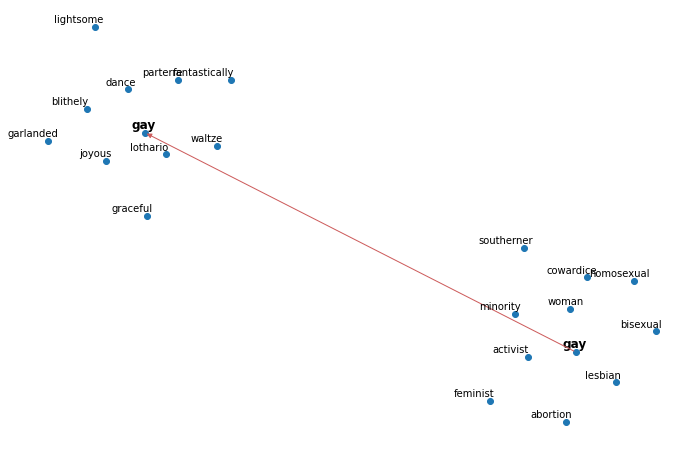

In [46]:
# example

y = vizualize('gay')

**Your turn**: find the most and the least changed words from the SemEval list. Can you see the difference between their trajectories?